In [3]:
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, './orchard')

from orchard.find_missing_trees import *
from orchard.aerobotics_requests import *

In [2]:
orchard_id = 216269

### Step 1: Get the orchard details and the coordinates of trees from the latest survey

In [3]:
# Details of orchard; for polygon 
single_orchard_response = fetch_single_orchard(orchard_id)

# Get teh details of all surveys for current orchard
survey_response = fetch_all_orchard_surveys(orchard_id)
surveys = survey_response.json()["results"]  # TODO: Need to handle pagination
surveys_sorted_by_date = sorted(surveys, key=lambda survey: survey["date"])
latest_survey_id = surveys_sorted_by_date[-1]["id"]

# Get the trees for the latest survey
tree_surveys_response = fetch_single_survey(latest_survey_id)
tree_surveys = tree_surveys_response.json()

In [4]:
# ### Single Call
# m = findMissingTrees(orchard_response_json=single_orchard_response.json(), survey_response_json=tree_surveys_response.json())
# m

### Step 2: Store polygon data and tree data in two DataFrames

In [5]:
polygon_latlongs = single_orchard_response.json()["polygon"]

polygon_lng_data = [] # list of polygon lng coords
polygon_lat_data = [] # list of polygon lat coords
for l in polygon_latlongs.split(" "):
    l_split = l.split(",")
    polygon_lng_data.append(float(l_split[0]))
    polygon_lat_data.append(float(l_split[1]))
polygon_n_points = len(polygon_lat_data) # n points in polygon

polygon_df = pd.DataFrame({"lng": polygon_lng_data, "lat": polygon_lat_data})

trees_df = pd.DataFrame(tree_surveys["results"])

#### Remove trees randomly as a check

In [6]:
# Remove rows randomly from trees_df
# n = 5
# rows_to_remove = trees_df.sample(n=n).index
# trees_df = trees_df.drop(rows_to_remove)

# Or remove percentage of dataset:
isRemoveRandom = True
if (isRemoveRandom):
    frac = 0.05
    rows_to_remove = trees_df.sample(frac=frac).index
    trees_df = trees_df.drop(rows_to_remove)

#### Current Orchard with Missing Trees

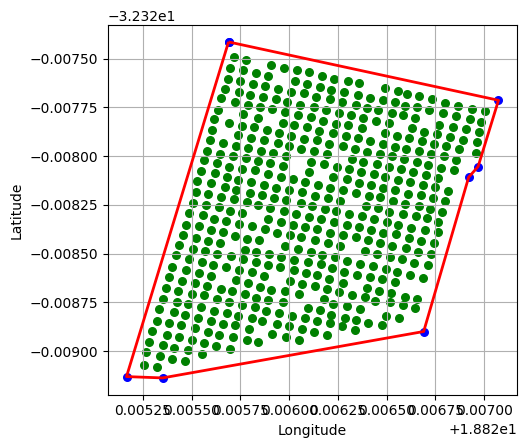

In [7]:
# Points for plotting corners
polygon_points = [Point(xy) for xy in zip(polygon_df['lng'], polygon_df['lat'])]
polygon_points_gdf = gpd.GeoDataFrame(polygon_df, geometry=polygon_points)

# Polygon shape from points
polygon_geometry = Polygon(polygon_points)
polygon_geometry_gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon_geometry])

# Points for Trees
tree_points = [Point(xy) for xy in zip(trees_df['lng'], trees_df['lat'])]
tree_points_gdf = gpd.GeoDataFrame(trees_df, geometry=tree_points)

# Plot points
ax = polygon_points_gdf.plot(marker='o', color='blue', markersize=30, label="Polygon Corners")
# Plot polygon on same axis as points
polygon_geometry_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label="Polygon Sides")
# Plot trees
tree_points_gdf.plot(ax=ax, marker='o', color='green', markersize=30, label="Trees")

# Bounding Box of polygon
poly_min_x, poly_min_y, poly_max_x, poly_max_y = polygon_geometry.bounds


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

plt.show()

### Step 3: Cluster Trees the Two Directions

In [8]:
x = np.array(trees_df['lng'])
y = np.array(trees_df['lat'])

# Find slopes of both directions
slopes = find_orchard_slopes(x,y)

dir_1_slope = slopes[0]
dir_2_slope = slopes[1]

# Clusters according to slope
# Get the y-intercept of a cluster for the current direction and the labels
dir_1_y_intercepts, dir_1_labels = cluster_trees_by_slope(x,y,slopes[0])
dir_2_y_intercepts, dir_2_labels = cluster_trees_by_slope(x,y,slopes[1])   

# Add the labels to the trees dataframe
trees_df["dir_1_labels"] = dir_1_labels
trees_df["dir_2_labels"] = dir_2_labels

# Print clustering results
print("Direction 1 slope: ", dir_1_slope)
print("Direction 2 slope: ", dir_2_slope)
print("Clusters for Direction 1: ", len(dir_1_y_intercepts))
print("Clusters for Direction 2: ", len(dir_2_y_intercepts))

c:\Users\benjr\Repos\Aerobotics_Technical_Assessment\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\benjr\Repos\Aerobotics_Technical_Assessment\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Direction 1 slope:  3.696730644152537
Direction 2 slope:  -0.23274052996008368
Clusters for Direction 1:  21
Clusters for Direction 2:  30


#### Plot Direction Clusters

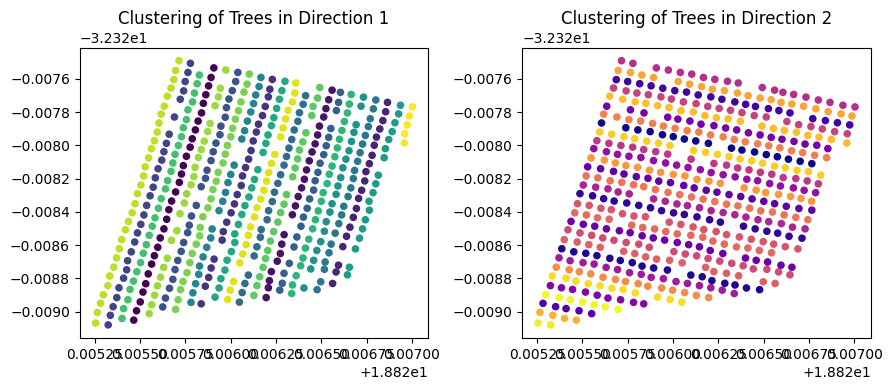

In [9]:
# Plot the clustering
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Dir 1 plot
scatter_1 = axes[0].scatter(x, y, c=dir_1_labels, cmap='viridis', s=20)
axes[0].set_title("Clustering of Trees in Direction 1")
# Dir 2 plot
scatter_2 = axes[1].scatter(x, y, c=dir_2_labels, cmap='plasma', s=20)
axes[1].set_title("Clustering of Trees in Direction 2")

plt.tight_layout()
plt.show()

### Step 4: Create LineString Grid, Find Outlier Distances, Map Tree Gaps to Grid

#### Geometry LineStrings in the current direction

In [10]:
# Geometry linestrings in the directions
dir_1_linestrings = linestrings_from_intercepts(dir_1_y_intercepts, dir_1_slope, poly_min_x, poly_max_x, poly_min_y, poly_max_y)
dir_2_linestrings = linestrings_from_intercepts(dir_2_y_intercepts, dir_2_slope, poly_min_x, poly_max_x, poly_min_y, poly_max_y)


#### Calculte the distance between adjacent trees and find outliers

In [11]:

# Calculate the distances between adjacent trees in a clustered direction
dir_1_distances, dir_1_distances_dict = distance_between_adj_trees(trees_df, len(dir_1_y_intercepts), 'dir_1_labels')
dir_2_distances, dir_2_distances_dict = distance_between_adj_trees(trees_df, len(dir_2_y_intercepts), 'dir_2_labels')

# Get the outlier distances; tree_from and tree_to
dir_1_outliers = find_distance_outliers(dir_1_distances, dir_1_distances_dict)
dir_2_outliers = find_distance_outliers(dir_2_distances, dir_2_distances_dict)

print("Direction 1 Outliers: ")
print(dir_1_outliers)
print("Direction 2 Outliers: ")
print(dir_2_outliers)


Direction 1 Outliers: 
[(np.int32(1), np.int64(54733194), np.int64(54732976), 13.969149262309573), (np.int32(2), np.int64(54732971), np.int64(54733011), 12.589447053268158), (np.int32(3), np.int64(54733112), np.int64(54732995), 13.373591586999995), (np.int32(3), np.int64(54732997), np.int64(54733061), 11.934750351024762), (np.int32(4), np.int64(54733408), np.int64(54733449), 12.214485604994131), (np.int32(4), np.int64(54733449), np.int64(54733440), 11.827905339608217), (np.int32(5), np.int64(54732957), np.int64(54733216), 12.735570181340671), (np.int32(6), np.int64(54733346), np.int64(54733245), 12.339645814178123), (np.int32(6), np.int64(54733022), np.int64(54733104), 11.215522565465537), (np.int32(7), np.int64(54733416), np.int64(54733046), 13.151233788006982), (np.int32(9), np.int64(54733286), np.int64(54733283), 17.885699305486213), (np.int32(9), np.int64(54733430), np.int64(54732985), 12.759941980742736), (np.int32(10), np.int64(54733341), np.int64(54733339), 12.570761017306605), 

#### Map outliers to grid and find intersection points between them

In [12]:
dir_1_missing_points = find_intersects_between_trees(trees_df, dir_1_outliers, dir_1_linestrings, dir_2_linestrings)
dir_2_missing_points = find_intersects_between_trees(trees_df, dir_2_outliers, dir_2_linestrings, dir_1_linestrings)

print(dir_1_missing_points)
print(dir_2_missing_points)

[<POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>]
[<POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18

#### Remove any duplicate points

In [13]:
# Remove Duplicate Points
missing_points_combined =  list(set(dir_1_missing_points + dir_2_missing_points))
print(len(missing_points_combined))
print(missing_points_combined)

28
[<POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>]


#### Output Result

In [14]:
# Missing trees to dict output format
missing_trees = []
for point in missing_points_combined:
    missing_trees.append({"lat": point.y, "lng": point.x})

missing_trees

[{'lat': -32.32890585147018, 'lng': 18.825867773573727},
 {'lat': -32.32862533075777, 'lng': 18.82567008475274},
 {'lat': -32.32806192201777, 'lng': 18.826028024759793},
 {'lat': -32.32873036983427, 'lng': 18.826121398825606},
 {'lat': -32.328625363070024, 'lng': 18.82594364829308},
 {'lat': -32.32782481748305, 'lng': 18.826701534953543},
 {'lat': -32.327865731061365, 'lng': 18.82567009531086},
 {'lat': -32.3286688266649, 'lng': 18.82661180046273},
 {'lat': -32.328803758395544, 'lng': 18.826436722337554},
 {'lat': -32.32866266850397, 'lng': 18.82634114296104},
 {'lat': -32.32877127666698, 'lng': 18.82604298663529},
 {'lat': -32.32750642126898, 'lng': 18.825835654672318},
 {'lat': -32.32813492585844, 'lng': 18.82682672581748},
 {'lat': -32.32830231010951, 'lng': 18.825826366415416},
 {'lat': -32.32844945345428, 'lng': 18.82592319390415},
 {'lat': -32.32759315919208, 'lng': 18.8259492967552},
 {'lat': -32.32800101263585, 'lng': 18.826251350215244},
 {'lat': -32.32824441742554, 'lng': 18.

#### Plot of missing trees

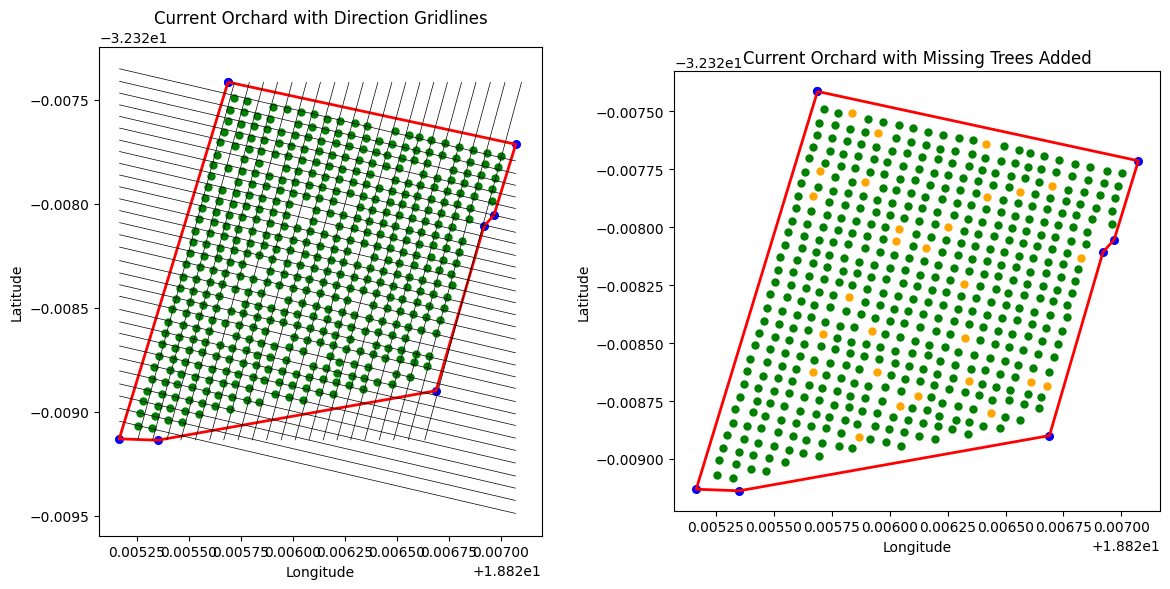

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot polygon corners
polygon_points_gdf.plot(ax=axes[0], marker='o', color='blue', markersize=30, label="Polygon Corners")
polygon_points_gdf.plot(ax=axes[1], marker='o', color='blue', markersize=30, label="Polygon Corners")
# Plot polygon sides
polygon_geometry_gdf.boundary.plot(ax=axes[0], color='red', linewidth=2, label="Polygon Sides")
polygon_geometry_gdf.boundary.plot(ax=axes[1], color='red', linewidth=2, label="Polygon Sides")


# Plot trees with gridlines on axes[0]
tree_points_gdf.plot(ax=axes[0], marker='o', color='green', markersize=25, label="Trees")
# Line Geometry for Grid
dir_1_geom_df = gpd.GeoDataFrame(geometry=dir_1_linestrings)
dir_1_geom_df.plot(ax=axes[0], color='black', linewidth=0.5)

dir_2_geom_df = gpd.GeoDataFrame(geometry=dir_2_linestrings)
dir_2_geom_df.plot(ax=axes[0], color='black', linewidth=0.5)

axes[0].set_title("Current Orchard with Direction Gridlines")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")


# Plot trees with missing trees on axes[1]
tree_points_gdf.plot(ax=axes[1], marker='o', color='green', markersize=25, label="Trees")
# Missing Trees
missing_points_combined_gdf = gpd.GeoDataFrame(geometry=missing_points_combined)
missing_points_combined_gdf.plot(ax=axes[1], marker='o', color='orange', markersize=25)

axes[1].set_title("Current Orchard with Missing Trees Added")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")


plt.tight_layout()
plt.show()